In [166]:
from logging import raiseExceptions
from tokenize import Double
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from vec3 import Vec3
import meshplot as mp
import torch
torch.manual_seed(125)
import random
random.seed(125)
import torch_f as torch_f

In [167]:
def count_fn(f):
    def wrapper(*args, **kwargs):
        wrapper.count += 1
        return f(*args, **kwargs)
    wrapper.count = 0
    return wrapper

Clase nodo

In [168]:
class Node:
    """
    Class Node
    """
    def __init__(self, value, radius, left = None, right = None, position = None, cl_prob= None, ce = None, mse = None, level = None, treelevel = None):
        self.left = left
        self.data = value
        self.radius = radius
        self.position = position
        self.right = right
        self.prob = cl_prob
        self.mse = mse
        self.ce = ce
        self.children = [self.left, self.right]
        self.level = level
        self.treelevel = treelevel
    
    def agregarHijo(self, children):

        if self.right is None:
            self.right = children
        elif self.left is None:
            self.left = children

        else:
            raise ValueError ("solo arbol binario ")


    def is_leaf(self):
        if self.right is None:
            return True
        else:
            return False

    def is_two_child(self):
        if self.right is not None and self.left is not None:
            return True
        else:
            return False

    def is_one_child(self):
        if self.is_two_child():
            return False
        elif self.is_leaf():
            return False
        else:
            return True

    def childs(self):
        if self.is_leaf():
            return 0
        if self.is_one_child():
            return 1
        else:
            return 2
    
    
    def traverseInorder(self, root):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.traverseInorder(root.left)
            print (root.data, root.radius)
            self.traverseInorder(root.right)

    def traverseInorderwl(self, root):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.traverseInorderwl(root.left)
            print (root.data, root.radius, root.level, root.treelevel)
            self.traverseInorderwl(root.right)

    def get_tree_level(self, root, c):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.get_tree_level(root.left, c)
            c.append(root.level)
            self.get_tree_level(root.right, c)

    def set_tree_level(self, root, c):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.set_tree_level(root.left, c)
            root.treelevel = c
            self.set_tree_level(root.right, c)

    def traverseInorderLoss(self, root, loss):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.traverseInorderLoss(root.left, loss)
            loss.append(root.prob)
            self.traverseInorderLoss(root.right, loss)
            return loss

    def traverseInorderMSE(self, root, loss):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.traverseInorderMSE(root.left, loss)
            loss.append(root.mse)
            self.traverseInorderMSE(root.right, loss)
            return loss

    def traverseInorderCE(self, root, loss):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.traverseInorderCE(root.left, loss)
            loss.append(root.ce)
            self.traverseInorderCE(root.right, loss)
            return loss

    def traverseInorderChilds(self, root, l):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.traverseInorderChilds(root.left, l)
            l.append(root.childs())
            self.traverseInorderChilds(root.right, l)
            return l

    def preorder(self, root):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            print (root.data, root.radius)
            self.preorder(root.left)
            self.preorder(root.right)

    def cloneBinaryTree(self, root):
     
        # base case
        if root is None:
            return None
    
        # create a new node with the same data as the root node
        root_copy = Node(root.data, root.radius)
    
        # clone the left and right subtree
        root_copy.left = self.cloneBinaryTree(root.left)
        root_copy.right = self.cloneBinaryTree(root.right)
    
        # return cloned root node
        return root_copy

    def height(self, root):
    # Check if the binary tree is empty
        if root is None:
            return 0 
        # Recursively call height of each node
        leftAns = self.height(root.left)
        rightAns = self.height(root.right)
    
        # Return max(leftHeight, rightHeight) at each iteration
        return max(leftAns, rightAns) + 1

    # Print nodes at a current level
    def printCurrentLevel(self, root, level):
        if root is None:
            return
        if level == 1:
            print(root.data, end=" ")
        elif level > 1:
            self.printCurrentLevel(root.left, level-1)
            self.printCurrentLevel(root.right, level-1)

    def printLevelOrder(self, root):
        h = self.height(root)
        for i in range(1, h+1):
            self.printCurrentLevel(root, i)


    
    def count_nodes(self, root, counter):
        if   root is not None:
            self.count_nodes(root.left, counter)
            counter.append(root.data)
            self.count_nodes(root.right, counter)
            return counter

    
    def serialize(self, root):
        def post_order(root):
            if root:
                post_order(root.left)
                post_order(root.right)
                ret[0] += str(root.data)+'_'+ str(root.radius) +';'
                
            else:
                ret[0] += '#;'           

        ret = ['']
        post_order(root)
        return ret[0][:-1]  # remove last ,

    def toGraph( self, graph, index, dec, proc=True):
        
        
        radius = self.radius.cpu().detach().numpy()
        if dec:
            radius= radius[0]
        #print("posicion", self.data, radius)
        #print("right", self.right)
        
        #graph.add_nodes_from( [ (index, {'posicion': radius[0:3], 'radio': radius[3] } ) ])
        graph.add_nodes_from( [ (self.data, {'posicion': radius[0:3], 'radio': radius[3] } ) ])
        

        if self.right is not None:
            #leftIndex = self.right.toGraph( graph, index + 1, dec)#
            self.right.toGraph( graph, index + 1, dec)#
            
            #graph.add_edge( index, index + 1 )
            graph.add_edge( self.data, self.right.data )
            #if proc:
            #    nx.set_edge_attributes( graph, {(index, index+1) : {'procesada':False}})
        
        if self.left is not None:
            #retIndex = self.left.toGraph( graph, leftIndex, dec )#
            self.left.toGraph( graph, 0, dec )#

            #graph.add_edge( index, leftIndex)
            graph.add_edge( self.data, self.left.data)
            #if proc:
            #    nx.set_edge_attributes( graph, {(index, leftIndex) : {'procesada':False}})

        else:
            #return index + 1
            return

Funciones extra

In [169]:
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

In [170]:
def plotTree( root, dec ):
    graph = nx.Graph()
    root.toGraph( graph, 0, dec)
    edges=nx.get_edge_attributes(graph,'procesada')

    p = mp.plot( np.array([ graph.nodes[v]['posicion'] for v in graph.nodes]), shading={'point_size':0.1}, return_plot=True)

    for arista in graph.edges:
        p.add_lines( graph.nodes[arista[0]]['posicion'], graph.nodes[arista[1]]['posicion'])

    return 

def traverse(root, tree):
       
        if root is not None:
            traverse(root.left, tree)
            tree.append((root.radius, root.data))
            traverse(root.right, tree)
            return tree

def traverse_2(tree1, tree2, t_l):
       
        if tree1 is not None:
            traverse_2(tree1.left, tree2.left, t_l)
            if tree2:
                t_l.append((tree1.radius, tree2.radius))
                print((tree1.radius, tree2.radius))
            else:
                t_l.append(tree1.radius)
                print((tree1.radius))
            traverse_2(tree1.right, tree2, t_l)
            return t_l
            

def traverse_conexiones(root, tree):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            traverse_conexiones(root.left, tree)
            if root.right is not None:
                tree.append((root.data, root.right.data))
            if root.left is not None:
                tree.append((root.data, root.left.data))
            traverse_conexiones(root.right, tree)
            return tree

def arbolAGrafo (nodoRaiz):
    
    conexiones = []
    lineas = traverse_conexiones(nodoRaiz, conexiones)
    tree = []
    tree = traverse(nodoRaiz, tree)

    vertices = []
    verticesCrudos = []
    for node in tree:
        vertice = node[0][0][:3]
        rad = node[0][0][-1]
        num = node[1]
        
        #vertices.append((num, {'posicion': Vec3( vertice[0], vertice[1], vertice[2]), 'radio': rad} ))
        vertices.append((len(verticesCrudos),{'posicion': Vec3( vertice[0], vertice[1], vertice[2]), 'radio': rad}))
        verticesCrudos.append(vertice)


    G = nx.Graph()
    G.add_nodes_from( vertices )
    G.add_edges_from( lineas )
    
    return G

@count_fn
def createNode(data, radius, position = None, left = None, right = None, cl_prob = None, ce = None, mse=None):
        """
        Utility function to create a node.
        """
        return Node(data, radius, position, left, right, cl_prob, ce, mse)
 
def deserialize(data):
    if  not data:
        return 
    nodes = data.split(';')  
    #print("node",nodes[3])
    def post_order(nodes):
                
        if nodes[-1] == '#':
            nodes.pop()
            return None
        node = nodes.pop().split('_')
        data = int(node[0])
        #radius = float(node[1])
        #print("node", node)
        #breakpoint()
        radius = node[1]
        #print("radius", radius)
        rad = radius.split(",")
        rad [0] = rad[0].replace('[','')
        rad [3] = rad[3].replace(']','')
        r = []
        for value in rad:
            r.append(float(value))
        #r =[float(num) for num in radius if num.isdigit()]
        r = torch.tensor(r, device=device)
        #breakpoint()
        root = createNode(data, r)
        root.right = post_order(nodes)
        root.left = post_order(nodes)
        
        return root    
    return post_order(nodes)    


def read_tree(filename):
    with open('./trees/' +'prof3/' +filename, "r") as f:
        byte = f.read() 
        return byte

Encoder

In [171]:
class InternalEncoder(nn.Module):
    
    def __init__(self, input_size: int, feature_size: int, hidden_size: int):
        super(InternalEncoder, self).__init__()

        #print("init")
        # Encoders atributos
        self.attribute_lin_encoder_1 = nn.Linear(input_size,hidden_size)
        self.attribute_lin_encoder_2 = nn.Linear(hidden_size,hidden_size*2)
        self.attribute_lin_encoder_3 = nn.Linear(hidden_size*2,feature_size)

        # Encoders derecho e izquierdo
        self.right_lin_encoder_1 = nn.Linear(feature_size,hidden_size)
        self.right_lin_encoder_2 = nn.Linear(hidden_size,feature_size)

        self.left_lin_encoder_1  = nn.Linear(feature_size,hidden_size)
        self.left_lin_encoder_2  = nn.Linear(hidden_size,feature_size)

        # Encoder final
        self.final_lin_encoder_1 = nn.Linear(2*feature_size, feature_size)

        # Funciones / Parametros utiles
        self.tanh = nn.Tanh()
        self.feature_size = feature_size
        #print("fin")

    def forward(self, input, right_input, left_input):
        # Encodeo los atributos
        attributes = self.attribute_lin_encoder_1(input)
        attributes = self.tanh(attributes)
        attributes = self.attribute_lin_encoder_2(attributes)
        attributes = self.tanh(attributes)
        attributes = self.attribute_lin_encoder_3(attributes)
        attributes = self.tanh(attributes)
        #print("attributes", attributes)

        # Encodeo el derecho
        if right_input is not None:
            #print("right input", right_input)
            context = self.right_lin_encoder_1(right_input)
            context = self.tanh(context)
            context = self.right_lin_encoder_2(context)
            #print("context derecho", context)
            # Encodeo el izquierdo
            #print("left input", left_input)
            if left_input is not None:
                left = self.left_lin_encoder_1(left_input)
                #print("izquierdo", left.shape)
                left = self.tanh(left)
                context += self.left_lin_encoder_2(left)
                #print("context izquierdo", context.shape)
        else:
            context = torch.zeros(input.shape[0],self.feature_size, requires_grad=True, device=device)
        

        context = self.tanh(context)
        #print("context shape", context.shape)
        #print("attributes shape", attributes.shape)
        #if len(attributes.shape) == 1:
            #print("len(attributes.shape)",len(attributes.shape))
            #attributes = attributes.reshape(1, 128)
        #print("attributes shape", attributes.shape)

        feature = torch.cat((attributes,context), 1)
        #print("feature cat", feature.shape)

        feature = self.final_lin_encoder_1(feature)
        feature = self.tanh(feature)
        #print("output", feature)
        return feature

       
    

class GRASSEncoder(nn.Module):
    
    def __init__(self, input_size: int, feature_size : int, hidden_size: int):
        super(GRASSEncoder, self).__init__()
        self.leaf_encoder = InternalEncoder(input_size,feature_size, hidden_size)
        self.internal_encoder = InternalEncoder(input_size,feature_size, hidden_size)
        self.bifurcation_encoder = InternalEncoder(input_size,feature_size, hidden_size)
        
    def leafEncoder(self, node, right=None, left = None):
        return self.internal_encoder(node, right, left)
    def internalEncoder(self, node, right, left = None):
        return self.internal_encoder(node, right, left)
    def bifurcationEncoder(self, node, right, left):
        
        return self.bifurcation_encoder(node, right, left)

Grassencoder = GRASSEncoder(input_size = 4, feature_size=256, hidden_size=512)
Grassencoder = Grassencoder.to(device)


def encode_structure_fold(fold, root):
    
    
    def encode_node(node):
        
        if node is None:
            return
        
        if node.is_leaf():
            return fold.add('leafEncoder', node.radius)
        else:
            left = encode_node(node.left)
            right = encode_node(node.right)
            if left is not None:
             
                return fold.add('bifurcationEncoder', node.radius, right, left)
            else:
                return fold.add('internalEncoder', node.radius, right)
        

    encoding = encode_node(root)
    
    return encoding
  
def encode_structure(root):
    
    def encode_node(node):
          
        if node is None:
            return
        if node.is_leaf():
            return Grassencoder.leafEncoder(node.radius.reshape(-1,4))
        else :
            left = encode_node(node.left)
            right = encode_node(node.right)
            if left is not None:
                return Grassencoder.bifurcationEncoder(node.radius.reshape(-1,4), right, left)
            else:
                return Grassencoder.internalEncoder(node.radius.reshape(-1,4), right)
        

    encoding = encode_node(root)
   
    return encoding
  

extra

In [172]:
def numerar_nodos(root, count):
    if root is not None:
        numerar_nodos(root.left, count)
        root.data = len(count)
        count.append(1)
        numerar_nodos(root.right, count)
        return 


def traversefeatures(root, features):
       
    if root is not None:
        traversefeatures(root.left, features)
        features.append(root.radius)
        traversefeatures(root.right, features)
        return features

def norm(root, minx, miny, minz, minr, maxx, maxy, maxz, maxr):
    
    if root is not None:
        mx = minx.clone().detach()
        my = miny.clone().detach()
        mz = minz.clone().detach()
        mr = minr.clone().detach()
        Mx = maxx.clone().detach()
        My = maxy.clone().detach()
        Mz = maxz.clone().detach()
        Mr = maxr.clone().detach()
       
        root.radius[0] = (root.radius[0] - minx)/(maxx - minx)
        root.radius[1] = (root.radius[1] - miny)/(maxy - miny)
        root.radius[2] = (root.radius[2] - minz)/(maxz - minz)
        root.radius[3] = (root.radius[3] - minr)/(maxr - minr)
        
        norm(root.left, mx, my, mz, mr, Mx, My, Mz, Mr)
        norm(root.right, mx, my, mz, mr, Mx, My, Mz, Mr)
        return 

def normalize_features(root):
    features = []
    features = traversefeatures(root, features)
    
    x = [tensor[0] for tensor in features]
    y = [tensor[1] for tensor in features]
    z = [tensor[2] for tensor in features]
    r = [tensor[3] for tensor in features]
 
    norm(root, min(x), min(y), min(z), min(r), max(x), max(y), max(z), max(r))

    return 

def traversefeatures(root, features):
       
    if root is not None:
        traversefeatures(root.left, features)
        features.append(root.radius)
        traversefeatures(root.right, features)
        return features


Data loader

In [173]:
def my_collate(batch):
    return batch

#t_list = ['ArteryObjAN1-7.dat','ArteryObjAN1-0.dat', 'ArteryObjAN1-17.dat',  'ArteryObjAN1-11.dat']

#t_list = ['ArteryObjAN1-0.dat','ArteryObjAN1-7.dat', 'ArteryObjAN1-17.dat',  'ArteryObjAN1-11.dat', 'ArteryObjAN1-19.dat', 'ArteryObjAN2-4.dat', 'ArteryObjAN2-6.dat', 
#           'ArteryObjAN25-18.dat']
#t_list = ['ArteryObjAN1-17-55.dat', 'ArteryObjAN1-17-22.dat', "ArteryObjAN1-17-12.dat", "ArteryObjAN1-17-9.dat",'ArteryObjAN1-17-42.dat', 'ArteryObjAN1-17-64.dat', "ArteryObjAN1-17-70.dat", "ArteryObjAN1-17-1.dat"]
#t_list = ['ArteryObjAN1-17.dat']
#t_list = ['ArteryObjAN1-11.dat']


#t_list = ['test2.dat']

#t_list = ['ArteryObjAN31-14.dat']
#t_list = os.listdir("./trees")[:20]
t_list = os.listdir("./trees/prof3")[:10]
print(t_list)
class tDataset(Dataset):
    def __init__(self, dir, transform=None):
        self.names = dir
        self.transform = transform
        self.data = [] #lista con las strings de todos los arboles
        for file in self.names:
            self.data.append(read_tree(file))
        self.trees = []
        for tree in self.data:
            deserial = deserialize(tree)
            normalize_features(deserial)
            self.trees.append(deserial)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        #file = self.names[idx]
        #string = read_tree(file)
        tree = self.trees[idx]
        return tree

batch_size = 10
dataset = tDataset(t_list)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True, collate_fn=my_collate)


['tree0.dat', 'tree1.dat', 'tree10.dat', 'tree11.dat', 'tree12.dat', 'tree13.dat', 'tree14.dat', 'tree15.dat', 'tree16.dat', 'tree17.dat']


In [174]:
input = iter(data_loader).next()[0]
plotTree(input, False)
input.traverseInorder(input)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5, 0.5,…

4 tensor([0.4444, 0.2000, 0.2222, 0.5000], device='cuda:0')
0 tensor([0., 0., 0., 0.], device='cuda:0')
3 tensor([0.8889, 0.4000, 0.4444, 1.0000], device='cuda:0')
1 tensor([0.5556, 0.8000, 0.7778, 0.5000], device='cuda:0')
2 tensor([1., 1., 1., 1.], device='cuda:0')


In [175]:
import torch_f
enc_fold = torch_f.Fold(device)
enc_fold_nodes = []     # list of fold nodes for encoding, lista con la "hoja de ruta" de los dos arboles
batch = iter(data_loader).next()
#for example in batch:
        #enc_fold.add('leafEncoder', example.radius)
        #enc_fold_nodes.append(enc_fold.add('leafEncoder', example.radius))
        #enc_fold_nodes.append(encode_structure_fold(enc_fold, example))

        #print("enc fold nodes", enc_fold)
for example in data_loader:
        example = example[0]
        enc_fold_nodes.append(encode_structure_fold(enc_fold, example))
enc_fold_nodes = enc_fold.apply(Grassencoder, [enc_fold_nodes])
print("ENCODED con batch",enc_fold_nodes)

ENCODED con batch [tensor([[-4.0991e-02,  3.7937e-02,  1.4489e-02, -3.8284e-02,  7.1172e-03,
         -2.0350e-02, -3.0817e-02, -2.4126e-02, -3.0974e-02,  3.1869e-02,
          1.0023e-01, -6.5026e-02,  4.3110e-02,  5.5201e-02, -4.1470e-02,
         -3.6200e-02, -6.1063e-02, -2.9893e-02,  7.9525e-02,  8.6626e-03,
          4.1159e-02,  1.3158e-02, -4.6662e-02, -1.9157e-02,  3.4661e-02,
         -2.6606e-02, -7.4691e-04, -8.4020e-02,  4.9588e-02,  2.7434e-02,
          4.8398e-03,  1.6214e-01,  7.0365e-03, -1.3736e-02,  1.0991e-02,
         -1.9707e-02,  4.0069e-02,  4.5624e-02,  2.7545e-02, -5.0406e-02,
         -9.0993e-03,  3.6015e-02, -4.7160e-02, -5.7786e-02, -5.0426e-02,
         -1.2140e-02,  3.8423e-02, -1.1976e-01,  4.8500e-02, -1.8128e-02,
          3.5993e-02,  6.0112e-02, -2.5072e-03, -4.3994e-02,  6.7696e-02,
         -2.4995e-02,  3.2436e-02, -3.2388e-02, -6.6341e-02,  4.3642e-02,
          2.0474e-02,  6.4475e-02,  3.1930e-02,  1.7211e-02, -9.2123e-02,
         -6.4129e-0

In [176]:
for data in data_loader:
    data = data[0]

enc_f = encode_structure(example).to(device)

print("encodeado sin batch", enc_f)

encodeado sin batch tensor([[-4.0991e-02,  3.7937e-02,  1.4489e-02, -3.8284e-02,  7.1172e-03,
         -2.0350e-02, -3.0817e-02, -2.4126e-02, -3.0974e-02,  3.1869e-02,
          1.0023e-01, -6.5026e-02,  4.3110e-02,  5.5201e-02, -4.1470e-02,
         -3.6200e-02, -6.1063e-02, -2.9893e-02,  7.9525e-02,  8.6626e-03,
          4.1159e-02,  1.3158e-02, -4.6662e-02, -1.9157e-02,  3.4661e-02,
         -2.6606e-02, -7.4691e-04, -8.4020e-02,  4.9588e-02,  2.7434e-02,
          4.8398e-03,  1.6214e-01,  7.0365e-03, -1.3736e-02,  1.0991e-02,
         -1.9707e-02,  4.0069e-02,  4.5624e-02,  2.7545e-02, -5.0406e-02,
         -9.0993e-03,  3.6015e-02, -4.7160e-02, -5.7786e-02, -5.0426e-02,
         -1.2140e-02,  3.8423e-02, -1.1976e-01,  4.8500e-02, -1.8128e-02,
          3.5993e-02,  6.0112e-02, -2.5072e-03, -4.3994e-02,  6.7696e-02,
         -2.4995e-02,  3.2436e-02, -3.2388e-02, -6.6341e-02,  4.3642e-02,
          2.0474e-02,  6.4475e-02,  3.1930e-02,  1.7211e-02, -9.2123e-02,
         -6.4129e-

In [177]:
enc_fold_nodes[0]-enc_f

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [178]:
n_no = []
qzero = 0
qOne = 0
qtwo = 0

for batch in data_loader:
    for tree in batch:
        count = []
        n = tree.count_nodes(tree, count)
        n_no.append(len(n))
        li = []
        tree.traverseInorderChilds(tree, li)
        zero = [a for a in li if a == 0]
        one = [a for a in li if a == 1]
        two = [a for a in li if a == 2]
        qzero += len(zero)
        qOne += len(one)
        qtwo += len(two)

print(len(data_loader)*batch_size)
print(n_no)
nprom = np.mean(n_no)
print(nprom)
qzero /= len(data_loader)*batch_size
qOne /= len(data_loader)*batch_size
qtwo /= len(data_loader)*batch_size

print(qzero)
print(qOne)
print(qtwo)

10
[3, 5, 5, 5, 5, 6, 3, 5, 6, 5]
4.8
3.0
0.6
1.2


en el loop creo un fold, mando este fold con cada uno de los arboles del batch a encode_structure_fold

Clasificador

In [179]:
class NodeClassifier(nn.Module):
    
    def __init__(self, latent_size : int, hidden_size : int):
        super(NodeClassifier, self).__init__()
        self.mlp1 = nn.Linear(latent_size, hidden_size)
        self.mlp2 = nn.Linear(hidden_size, hidden_size)
        self.mlp3 = nn.Linear(hidden_size, 3)
        self.tanh = nn.Tanh()

    def forward(self, input_feature):
        #print("classifier input", input_feature)
        output = self.mlp1(input_feature)
        output = self.tanh(output)
        output = self.mlp2(output)
        output = self.tanh(output)
        output = self.mlp3(output)
        #print("classifier output", output)

        return output


Decoder

In [180]:
'''class InternalDecoder(nn.Module):
    
    """ Decode an input (parent) feature into a left-child and a right-child feature """
    def __init__(self, latent_size : int, hidden_size: int):
        super(InternalDecoder, self).__init__()
        self.mlp = nn.Linear(latent_size,hidden_size)
        self.lp2 = nn.Linear(hidden_size, latent_size)
        self.mlp_right = nn.Linear(latent_size, latent_size)
        self.tanh = nn.Tanh()
        self.mlp2 = nn.Linear(latent_size,4)

    def forward(self, parent_feature):
        #print("internal decoder")
        #print("input", parent_feature.shape)
        vector = self.mlp(parent_feature)
        vector = self.tanh(vector)
        vector = self.lp2(vector)
        vector = self.tanh(vector)
        right_feature = self.mlp_right(vector)
        right_feature = self.tanh(right_feature)
        rad_feature = self.mlp2(vector)

        return right_feature, rad_feature

class BifurcationDecoder(nn.Module):
    
    """ Decode an input (parent) feature into a left-child and a right-child feature """
    def __init__(self, latent_size : int, hidden_size : int):
        super(BifurcationDecoder, self).__init__()
        #self.mlp = nn.Linear(latent_size,hidden_size)
        self.mlp = nn.Linear(latent_size,hidden_size)
        self.lp2 = nn.Linear(hidden_size, latent_size)
        self.mlp_left = nn.Linear(latent_size, latent_size)
        self.mlp_right = nn.Linear(latent_size, latent_size)
        self.mlp2 = nn.Linear(latent_size,4)
        self.tanh = nn.Tanh()

    def forward(self, parent_feature):
        #print("bifurcation decoder input", parent_feature.shape)
        parent_feature = parent_feature.reshape(-1,128)
        #print("bifurcation decoder input", parent_feature.shape)
        vector = self.mlp(parent_feature)
        #print("v1", vector.shape)
        vector = self.tanh(vector)
        #print("v2", vector.shape)
        vector = self.lp2(vector)
        #print("v3", vector.shape)
        vector = self.tanh(vector)
        left_feature = self.mlp_left(vector)
        left_feature = self.tanh(left_feature)
        right_feature = self.mlp_right(vector)
        right_feature = self.tanh(right_feature)
        rad_feature = self.mlp2(vector)
        #print("exiting bif dec")
        return left_feature, right_feature, rad_feature


class featureDecoder(nn.Module):
    
    """ Decode an input (parent) feature into a left-child and a right-child feature """
    def __init__(self, latent_size : int, hidden_size: int):
        super(featureDecoder, self).__init__()
        self.mlp = nn.Linear(latent_size,hidden_size)
        self.mlp2 = nn.Linear(hidden_size, latent_size)
        self.mlp3 = nn.Linear(latent_size, latent_size)
        self.tanh = nn.Tanh()
        self.mlp4 = nn.Linear(latent_size,4)

    def forward(self, parent_feature):
        #print("feature decoder input", parent_feature.shape)

        vector = self.mlp(parent_feature)
        vector = self.tanh(vector)
        vector = self.mlp2(vector)
        vector = self.tanh(vector)
        vector = self.mlp3(vector)
        vector = self.tanh(vector)
        vector = self.mlp4(vector)
       
        return vector



class GRASSDecoder(nn.Module):
    def __init__(self, latent_size : int, hidden_size: int, mult: torch.Tensor):
        super(GRASSDecoder, self).__init__()
        self.feature_decoder = featureDecoder(latent_size, hidden_size)
        self.internal_decoder = InternalDecoder(latent_size, hidden_size)
        self.bifurcation_decoder = BifurcationDecoder(latent_size, hidden_size)
        self.node_classifier = NodeClassifier(latent_size, hidden_size)
        self.mseLoss = nn.MSELoss()  # pytorch's mean squared error loss
        self.ceLoss = nn.CrossEntropyLoss(weight = mult)  # pytorch's cross entropy loss (NOTE: no softmax is needed before)

    def featureDecoder(self, feature):
        return self.feature_decoder(feature)

    def internalDecoder(self, feature):
        return self.internal_decoder(feature)

    def bifurcationDecoder(self, feature):
        return self.bifurcation_decoder(feature)

    def nodeClassifier(self, feature):
        return self.node_classifier(feature)

    def calcularLossAtributo(self, nodo, radio):
        if nodo is None:
            return
        else:
            #print("radio", radio)
            #print("nodo", nodo)
            nodo = torch.stack(nodo)
            #print("nodo stack", nodo)
            #radio = radio.reshape(-1,4)
        
            #return mse
            #return torch.cat([self.mseLoss(b, gt) for b, gt in zip(radio, nodo)], 0)
            z = zip(radio.reshape(-1,4), nodo.reshape(-1,4))
            
            #for b, gt in z:
            #    print("bgt", b, gt)
                
            
            l = [self.mseLoss(b.reshape(1,4), gt.reshape(1,4)) for b, gt in zip(radio.reshape(-1,4), nodo.reshape(-1,4))]
            #print("loss", l)
            return l


    def classifyLossEstimator(self, label_vector, original):
        if original is None:
            return
        else:
           
            v = []
            for o in original:
                if o == 0:
                    vector = torch.tensor([1, 0, 0], device=device, dtype = torch.float)
                if o == 1:
                    vector = torch.tensor([0, 1, 0], device=device, dtype = torch.float)
                if o == 2:
                    vector = torch.tensor([0, 0, 1], device=device, dtype = torch.float)
                v.append(vector)

            v = torch.stack(v)
            z = zip(label_vector.reshape(-1,3), v.reshape(-1,3))   
            l = [self.ceLoss(b.reshape(1,3), gt.reshape(1,3)).mul(0.4) for b, gt in zip(label_vector.reshape(-1,3), v.reshape(-1,3))]
            
            return l
            #return c
       # return torch.cat([self.creLoss(l.unsqueeze(0), gt).mul(0.2) for l, gt in zip(label_vector, gt_label_vector)], 0)

    def vectorAdder(self, v1, v2, v3 = None, v4 = None):
        
        v = v1.add(v2)
        #print("v0", v)
        if v3 is not None:
            v = v.add(v3)
        #print("v0", v)
        if v4 is not None:
            v = v.add(v4)
       
        return v
if qzero == 0:
    qzero = 1
if qOne == 0:
    qOne = 1
if qtwo == 0:
    qtwo = 1
mult = torch.tensor([1/round(qzero),1/round(qOne),1/round(qtwo)], device = device)
Grassdecoder = GRASSDecoder(latent_size=128, hidden_size=256, mult = mult)
Grassdecoder = Grassdecoder.to(device)
'''

'class InternalDecoder(nn.Module):\n    \n    """ Decode an input (parent) feature into a left-child and a right-child feature """\n    def __init__(self, latent_size : int, hidden_size: int):\n        super(InternalDecoder, self).__init__()\n        self.mlp = nn.Linear(latent_size,hidden_size)\n        self.lp2 = nn.Linear(hidden_size, latent_size)\n        self.mlp_right = nn.Linear(latent_size, latent_size)\n        self.tanh = nn.Tanh()\n        self.mlp2 = nn.Linear(latent_size,4)\n\n    def forward(self, parent_feature):\n        #print("internal decoder")\n        #print("input", parent_feature.shape)\n        vector = self.mlp(parent_feature)\n        vector = self.tanh(vector)\n        vector = self.lp2(vector)\n        vector = self.tanh(vector)\n        right_feature = self.mlp_right(vector)\n        right_feature = self.tanh(right_feature)\n        rad_feature = self.mlp2(vector)\n\n        return right_feature, rad_feature\n\nclass BifurcationDecoder(nn.Module):\n    \n  

In [181]:
class Decoder(nn.Module):
    
    """ Decode an input (parent) feature into a left-child and a right-child feature """
    def __init__(self, latent_size : int, hidden_size : int):
        super(Decoder, self).__init__()
        #self.mlp = nn.Linear(latent_size,hidden_size)
        self.mlp = nn.Linear(latent_size,hidden_size)
        self.lp2 = nn.Linear(hidden_size, hidden_size)
        self.lp3 = nn.Linear(hidden_size, latent_size)

        self.mlp_left = nn.Linear(latent_size, hidden_size)
        self.mlp_left2 = nn.Linear(hidden_size, latent_size)
        self.mlp_right = nn.Linear(latent_size, hidden_size)
        self.mlp_right2 = nn.Linear(hidden_size, latent_size)

        self.mlp2 = nn.Linear(latent_size,latent_size)
        self.mlp3 = nn.Linear(latent_size,4)
        self.tanh = nn.Tanh()

    def common_branch(self, parent_feature):
        vector = self.mlp(parent_feature)
        vector = self.tanh(vector)
        vector = self.lp2(vector)
        vector = self.tanh(vector)
        vector = self.lp3(vector)
        vector = self.tanh(vector)
        return vector

    def attr_branch(self, vector):
        vector = self.mlp2(vector)
        vector = self.tanh(vector)
        vector = self.mlp3(vector)        
        return vector

    def right_branch(self, vector):
        right_feature = self.mlp_right(vector)
        right_feature = self.tanh(right_feature)
        right_feature = self.mlp_right2(right_feature)
        right_feature = self.tanh(right_feature)
        return right_feature

    def left_branch(self, vector):
        left_feature = self.mlp_left(vector)
        left_feature = self.tanh(left_feature)
        left_feature = self.mlp_left2(left_feature)
        left_feature = self.tanh(left_feature)
        return left_feature

    def forward(self, parent_feature):
      
        vector      = self.common_branch(parent_feature)
        attr_vector = self.attr_branch(vector)
        return attr_vector 

    def forward1(self, parent_feature):
    

        vector       = self.common_branch(parent_feature)
        attr_vector  = self.attr_branch(vector)
        right_vector = self.right_branch(vector)
        
        #print("right vector", right_vector)
        #print("radius", attr_vector)
        return right_vector, attr_vector

    def forward2(self, parent_feature):
       

        vector       = self.common_branch(parent_feature)
        attr_vector  = self.attr_branch(vector)
        right_vector = self.right_branch(vector)
        left_vector  = self.left_branch(vector)
        #print("left vector", left_vector)
        #print("right vector", right_vector)
        #print("radius", attr_vector)
        return left_vector, right_vector, attr_vector



class GRASSDecoder(nn.Module):
    def __init__(self, latent_size : int, hidden_size: int, mult: torch.Tensor):
        super(GRASSDecoder, self).__init__()
        self.decoder = Decoder(latent_size, hidden_size)
        self.node_classifier = NodeClassifier(latent_size, hidden_size)
        self.mseLoss = nn.MSELoss()  # pytorch's mean squared error loss
        self.ceLoss = nn.CrossEntropyLoss(weight = mult)  # pytorch's cross entropy loss (NOTE: no softmax is needed before)
        


    def featureDecoder(self, feature):
        return self.decoder.forward(feature)

    def internalDecoder(self, feature):
        return self.decoder.forward1(feature)

    def bifurcationDecoder(self, feature):
        return self.decoder.forward2(feature)

    def nodeClassifier(self, feature):
        return self.node_classifier(feature)

    def calcularLossAtributo(self, nodo, radio):
        #print("nodo", nodo)
        #print("radio", radio)
        a, b = list(zip(*nodo))# a son los atributos, b los pesos
        if nodo is None:
            return
        else:
            nodo = torch.stack(list(a))
        
            l = [self.mseLoss(b.reshape(1,4), gt.reshape(1,4)) for b, gt in zip(radio.reshape(-1,4), nodo.reshape(-1,4))]
            #print("mse", l)
            return l


    def classifyLossEstimator(self, label_vector, original):
        if original is None:
            return
        else:
           
            v = []
            for o in original:
                if o == 0:
                    vector = torch.tensor([1, 0, 0], device=device, dtype = torch.float)
                if o == 1:
                    vector = torch.tensor([0, 1, 0], device=device, dtype = torch.float)
                if o == 2:
                    vector = torch.tensor([0, 0, 1], device=device, dtype = torch.float)
                v.append(vector)
            

            v = torch.stack(v)
            
            l = [self.ceLoss(b.reshape(1,3), gt.reshape(1,3)).mul(0.4) for b, gt in zip(label_vector.reshape(-1,3), v.reshape(-1,3))]
         

            return l
            #return c

    '''
    def vectorAdder(self, v1, v2, v3 = None, v4 = None):
        
        print("loss estructura", v1)
        print("loss atributo", v2)
        print("right loss", v3)
        print("left loss", v4)


        v = v1.add(v2)
        #print("v0", v)
        if v3 is not None:
            v = v.add(v3)
        #print("v0", v)
        if v4 is not None:
            v = v.add(v4)
       
        return v

    '''
    def vectorAdder(self, v1, v2):
        v = v1.add(v2)
        return v

    def vectorMult(self, m, v):
        #print("v", v)
        #print("m", m)
        z = zip(v, m)
        r = []
        for c, d in z:
            #print("v", c)
            #print("m", d)
            r.append(torch.mul(c, d))
        #res = [torch.mul(v, m) for v, m in zip(v, m)]
        #print("res", r)
        return r

if round(qzero) == 0:
    qzero = 1
if round(qOne) == 0:
    qOne = 1
if round(qtwo) == 0:
    qtwo = 1
mult = torch.tensor([1/round(qzero),1/round(qOne),1/round(qtwo)], device = device)

Grassdecoder = GRASSDecoder(latent_size=256, hidden_size=512, mult = mult)
Grassdecoder = Grassdecoder.to(device)

Decode structure

In [182]:
mult = torch.tensor([1/round(qzero),1/round(qOne),1/round(qtwo)], device = device)
print(mult)
def calcularLossEstructura(cl_p, original):
    
    if original is None:
        return
    mult = torch.tensor([1/round(qzero),1/round(qOne),1/round(qtwo)], device = device)
    ce = nn.CrossEntropyLoss(weight = mult)

    if original.childs() == 0:
        vector = [1, 0, 0] 
    if original.childs() == 1:
        vector = [0, 1, 0]
    if original.childs() == 2:
        vector = [0, 0, 1] 

    #print("original", vector)
    #print("prediction", cl_p)
    c = ce(cl_p, torch.tensor(vector, device=device, dtype = torch.float).reshape(1, 3))
    #print("ce", 0.4*c)
    return c


def calcularLossAtributo(nodo, radio):
    if nodo is None:
        return
    #print("nodo", nodo)
    #print("radio", radio)

    radio = radio.reshape(-1,4)
    nodo = nodo.radius.reshape(-1,4)
    l2    = nn.MSELoss()
   
    mse = l2(radio, nodo)
    #print("mse", mse)
    return mse

tensor([0.3333, 1.0000, 1.0000], device='cuda:0')


In [183]:
def searchNode(node, key):
     
    if (node == None):
        return False
 
    if (node.data == key):
        return node
        
 
    """ then recur on left subtree """
    res1 = searchNode(node.left, key)
    # node found, no need to look further
    if res1:
        return res1
 
    """ node is not found in left,
    so recur on right subtree """
    res2 = searchNode(node.right, key)
    return res2

In [184]:
def getLevelUtil(node, data, level):
    if (node == None):
        return 0
 
    if (node.data == data):
        return level
 
    downlevel = getLevelUtil(node.left, data, level + 1)

    if (downlevel != 0):
        return downlevel
 
    downlevel = getLevelUtil(node.right, data, level + 1)
    return downlevel
 
# Returns level of given data value
 
 
def getLevel(node, data):
    return getLevelUtil(node, data, 1)
 

c = []
n_nodes = input.count_nodes(input, c)
print("n_nodes", len(n_nodes))
for x in range(0, len(n_nodes)):
        level = getLevel(input, x)
        if (level):
            #print("Level of", x, "is", getLevel(input, x))
            node = searchNode(input, x)
            node.level = getLevel(input, x)
        else:
            print(x, "is not present in tree")

n_nodes 5


In [185]:
for d in data_loader:
    for data in d:
        print(data)
        count = []
        numerar_nodos(data, count)
        c = []
        n_nodes = data.count_nodes(data, c)
        for x in range(0, len(n_nodes)):
            level = getLevel(data, x)
            if (level):
                #print("Level of", x, "is", getLevel(input, x))
                node = searchNode(data, x)
                node.level = getLevel(data, x)
            else:
                print(x, "is not present in tree")
        tree_level = []
        data.get_tree_level(data, tree_level)
        print("tree level", sum(tree_level))
        data.set_tree_level(data, sum(tree_level))

tree level 11
tree level 11
tree level 11
tree level 11
tree level 6
tree level 11
tree level 14
tree level 6
tree level 11
tree level 14


In [186]:
def decode_structure_fold_grass(fold, v, root):
   
    def decode_node(fold, v, node):
        
        
        if node.childs() == 0 : 

            radio = fold.add('featureDecoder', v)
            lossAtributo = fold.add('calcularLossAtributo', node, radio)

            label = fold.add('nodeClassifier', v)
            
            lossEstructura = fold.add('classifyLossEstimator', label, node)  
            multipl = node.level/node.treelevel
            losse = fold.add('vectorMult', multipl, lossEstructura)
            
            loss =  fold.add('vectorAdder', losse, lossAtributo)       
            return loss

            
            
        elif node.childs() == 1 :
            right, radius = fold.add('internalDecoder', v).split(2)
            label = fold.add('nodeClassifier', v)
            nodoSiguiente = node.right
            if nodoSiguiente is not None:
                right_loss = decode_node(fold, right, nodoSiguiente)

            lossEstructura = fold.add('classifyLossEstimator', label, node)
            lossAtributo = fold.add('calcularLossAtributo', node, radius)
            multipl = node.level/node.treelevel
            losse = fold.add('vectorMult', multipl, lossEstructura)
            loss = fold.add('vectorAdder', losse, lossAtributo)
            
        
            loss2 = fold.add('vectorAdder', loss, right_loss)
            return loss2
            
            

        elif node.childs() == 2 :
            left, right, radius = fold.add('bifurcationDecoder', v).split(3)
            
            label = fold.add('nodeClassifier', v)            
            
            nodoSiguienteRight = node.right
            nodoSiguienteLeft = node.left


            if nodoSiguienteRight is not None:
                right_loss = decode_node(fold, right, nodoSiguienteRight)
             
            if nodoSiguienteLeft is not None:
                left_loss  = decode_node(fold, left, nodoSiguienteLeft)

            multipl = node.level/node.treelevel
            lossEstructura = fold.add('classifyLossEstimator', label, node)
            losse = fold.add('vectorMult', multipl, lossEstructura)
            lossAtributo   = fold.add('calcularLossAtributo', node, radius)
            loss = fold.add('vectorAdder', losse, lossAtributo)
            loss2 = fold.add('vectorAdder', loss, right_loss)
            loss3 = fold.add('vectorAdder', loss2, left_loss)
            
            return loss3
            

    dec = decode_node (fold, v, root)
    return dec



Decode testing

In [187]:
def decode_testing_grass(v, root, max, decoder):
    def decode_node(v, node, max, decoder):
        cl = decoder.nodeClassifier(v)
        _, label = torch.max(cl, 1)
        label = label.data
        
        
        if label == 0 and createNode.count <= max: ##output del classifier
           
            radio = decoder.featureDecoder(v)
            lossEstructura = calcularLossEstructura(cl, node)
            lossAtrs = calcularLossAtributo( node, radio )
            if lossEstructura is not None:
                multipl = node.level/node.treelevel
                lossEstructura = multipl*lossEstructura
            
            return createNode(1,radio, ce = lossEstructura,  mse = lossAtrs)

        elif label == 1 and createNode.count <= max:
       
            right, radius = decoder.internalDecoder(v)
            lossEstructura = calcularLossEstructura(cl, node)
            lossAtrs = calcularLossAtributo( node, radius )
            if lossEstructura is not None:
                multipl = node.level/node.treelevel
                lossEstructura = multipl*lossEstructura
            d = createNode(1, radius, ce = lossEstructura,  mse = lossAtrs) 
           
            if not node is None:
                if not node.right is None:
                    nodoSiguiente = node.right
                else:
                    nodoSiguiente = None
            else:
                nodoSiguiente = None
            
            d.right = decode_node(right, nodoSiguiente, max, decoder)
            

            return d
       
        elif label == 2 and createNode.count <= max:
            left, right, radius = decoder.bifurcationDecoder(v)
            lossEstructura = calcularLossEstructura(cl, node)
            lossAtrs = calcularLossAtributo( node, radius )
            if lossEstructura is not None:
                multipl = node.level/node.treelevel
                lossEstructura = multipl*lossEstructura
            
            d = createNode(1, radius, ce = lossEstructura,  mse = lossAtrs )
  
            if not node is None: #el nodo existe, me fijo si tiene hijo der/izq
                if not node.right is None:
                    nodoSiguienteRight = node.right
                else:
                    nodoSiguienteRight = None
                if not node.left is None:
                    nodoSiguienteLeft = node.left
                else:
                    nodoSiguienteLeft = None
            else: #el nodo no existe
                nodoSiguienteRight = None
                nodoSiguienteLeft = None
            
            d.right = decode_node(right, nodoSiguienteRight, max, decoder)
            d.left = decode_node(left, nodoSiguienteLeft, max, decoder)
            
           
            return d
            
    createNode.count = 0
    dec = decode_node (v, root, max, decoder)
    return dec

In [188]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, encoder, decoder, optimizer
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            #print(f"\nBest validation loss: {self.best_valid_loss}")
            #print(f"\nSaving best model for epoch: {epoch+1}\n")
            #'classifier_state_dict': classifier.state_dict(),
            torch.save({
                'epoch': epoch+1,
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
                
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'outputs/best_model.pth')

save_best_model = SaveBestModel()

training loop

In [189]:
def decode_structure_fold_(v, root):
    
    def decode_node(v, node):
        cl = Grassdecoder.nodeClassifier(v)
        _, label = torch.max(cl, 1)
        label = label.data

        
        if node.childs() == 0 : ##output del classifier
            lossEstructura = calcularLossEstructura(cl, node)
            radio = Grassdecoder.featureDecoder(v)
            lossAtrs = calcularLossAtributo( node.radius, radio )
            multipl = node.level/node.treelevel
            losse = multipl*lossEstructura
            nd = createNode(1,radio, ce = losse,  mse = lossAtrs)
            return nd

        elif node.childs() == 1 :
        
            right, radius = Grassdecoder.internalDecoder(v)
            lossEstructura = calcularLossEstructura(cl, node)
            lossAtrs = calcularLossAtributo( node.radius, radius )
            multipl = node.level/node.treelevel
            losse = multipl*lossEstructura
            nd = createNode(1, radius, cl_prob = lossAtrs , ce = losse, mse = lossAtrs) 
            
            nodoSiguiente = node.right
           
            if nodoSiguiente is not None:
                nd.right = decode_node(right, nodoSiguiente)
               
            return nd

        elif node.childs() == 2 :
            left, right, radius = Grassdecoder.bifurcationDecoder(v)
            lossEstructura = calcularLossEstructura(cl, node)
            lossAtrs = calcularLossAtributo( node.radius, radius )
            multipl = node.level/node.treelevel
            losse = multipl*lossEstructura
            nd = createNode(1, radius, cl_prob = lossAtrs, ce = losse, mse = lossAtrs)
            
            nodoSiguienteRight = node.right
            nodoSiguienteLeft = node.left

            
            if nodoSiguienteRight is not None:
                nd.right = decode_node(right, nodoSiguienteRight)
             
            if nodoSiguienteLeft is not None:
                nd.left  = decode_node(left, nodoSiguienteLeft)
            
            return nd
            
    createNode.count = 0
    dec = decode_node (v, root)
    return dec

Encoder con batch - decoder con batch

In [190]:
epochs = 8000
learning_rate = 1e-5
params = list(Grassencoder.parameters()) + list(Grassdecoder.parameters()) 

#opt = torch.optim.Adam(params, lr=learning_rate, weight_decay=0.0001) 
opt = torch.optim.Adam(params, lr=learning_rate) 
#opt = torch.optim.SGD(params, lr=learning_rate, momentum = 0.96) 

#scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[100], gamma=0.2)
import wandb
config = {
  "learning_rate": learning_rate,
  "epochs": epochs,
  "batch_size": batch_size,
  "dataset": t_list,
  "number of trees": len(data_loader)*batch_size,
  "optim": opt
}
wandb.init(project="autoencoder4", entity="paufeldman", config = config)

In [191]:

train_loss_avg = []

ce_avg = []
mse_avg = []
lr_list = []
    
for epoch in range(epochs):
    train_loss_avg.append(0)
   #batch es cada arbol del dataloader
    for batch_idx, batch in enumerate(data_loader):
        # Initialize torchfold for *encoding*

        
        enc_fold = torch_f.Fold(device)
        enc_fold_nodes = []     # list of fold nodes for encoding, lista con la "hoja de ruta" de los dos arboles
        # Collect computation nodes recursively from encoding process
        n_nodes = []
        for example in batch: #example es un arbolito
            c = []
            n = example.count_nodes(example, c)
            n_nodes.append(len(n))
            encode_structure_fold(enc_fold, example)
            enc_fold_nodes.append(encode_structure_fold(enc_fold, example))
       
        # Apply the computations on the encoder model
       
        enc_fold_nodes = enc_fold.apply(Grassencoder, [enc_fold_nodes])
        
        
        # Initialize torchfold for *decoding*
        dec_fold = torch_f.Fold(device)
        # Collect computation nodes recursively from decoding process
        dec_fold_nodes = []
        kld_fold_nodes = []

        t_l = []
        for f in enc_fold_nodes:
            for t in f:
                t_l.append(t)
        for example, fnode in zip(batch, t_l): #example es el arbol y fnode el encodeado
            #print("example", example)
            #print("fnode", fnode) 
            #root_code, kl_div = torch.chunk(fnode, 2, 0)
            dec_fold_nodes.append(decode_structure_fold_grass(dec_fold, fnode, example))
        # Apply the computations on the decoder model

                       
        total_loss = dec_fold.apply(Grassdecoder, [dec_fold_nodes])#[0]
        #print("total_loss", total_loss)
        n_nodes = torch.tensor(n_nodes, device = device)
        #print("n", n_nodes)
        total_loss = torch.div(total_loss[0], n_nodes)
        #print("div", total_loss)
        total_loss = total_loss.sum() / len(batch)  #n_nodes[0] #modificar y dividir por el promedio?
        total_loss = total_loss#*10
        
        #print("total_loss", total_loss)
        
        
        opt.zero_grad()
        total_loss.backward()
        opt.step()
        #scheduler.step()
        train_loss_avg[-1] += (total_loss.item())
        

    wandb.log({'epoch': epoch+1, 'loss': total_loss})
    save_best_model(
        total_loss, epoch, Grassencoder, Grassdecoder, opt)
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %.8f ' % (epoch+1, epochs, total_loss))
    

Epoch [1 / 8000] average reconstruction error: 0.32504568 
Epoch [11 / 8000] average reconstruction error: 0.31498209 
Epoch [21 / 8000] average reconstruction error: 0.30499563 
Epoch [31 / 8000] average reconstruction error: 0.29470032 
Epoch [41 / 8000] average reconstruction error: 0.28363237 
Epoch [51 / 8000] average reconstruction error: 0.27124572 
Epoch [61 / 8000] average reconstruction error: 0.25684214 
Epoch [71 / 8000] average reconstruction error: 0.23949979 
Epoch [81 / 8000] average reconstruction error: 0.21784483 
Epoch [91 / 8000] average reconstruction error: 0.18999055 
Epoch [101 / 8000] average reconstruction error: 0.15421091 
Epoch [111 / 8000] average reconstruction error: 0.11239133 
Epoch [121 / 8000] average reconstruction error: 0.07491596 
Epoch [131 / 8000] average reconstruction error: 0.05398503 
Epoch [141 / 8000] average reconstruction error: 0.04587218 
Epoch [151 / 8000] average reconstruction error: 0.04145901 
Epoch [161 / 8000] average reconstr

encoder con batch - decoder sin batch

In [192]:
'''
params = list(Grassencoder.parameters()) + list(Grassdecoder.parameters()) 

opt = torch.optim.Adam(params, lr=learning_rate) 

#scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[200], gamma=0.1)
    
train_loss_avg = []
#train_loss_avg.append(0)
ce_avg = []
mse_avg = []
lr_list = []
    
for epoch in range(epochs):
    train_loss_avg.append(0)
   #batch es cada arbol del dataloader
    for batch_idx, batch in enumerate(data_loader):
        # Initialize torchfold for *encoding*

        
        enc_fold = torch_f.Fold(device)
        enc_fold_nodes = []     # list of fold nodes for encoding, lista con la "hoja de ruta" de los dos arboles
        # Collect computation nodes recursively from encoding process
        n_nodes = []
        for example in batch: #example es un arbolito
            c = []
            n = example.count_nodes(example, c)
            n_nodes.append(len(n))
            encode_structure_fold(enc_fold, example)
            enc_fold_nodes.append(encode_structure_fold(enc_fold, example))
       
        # Apply the computations on the encoder model
       
        enc_fold_nodes = enc_fold.apply(Grassencoder, [enc_fold_nodes])
        encodeado_con_batch = enc_fold_nodes
        
        decoded = decode_structure_fold_(enc_fold_nodes[0], batch[0])
        #print("decoded", decoded)
        l = []
        mse_loss_list = decoded.traverseInorderMSE(decoded, l)
        l = []
        ce_loss_list = decoded.traverseInorderCE(decoded, l)
            
        mse_loss = sum(mse_loss_list) 
        ce_loss  = sum(ce_loss_list)  
        total_loss = (0.5*ce_loss + mse_loss)
        #print("total_loss", total_loss)
        total_loss = total_loss / len(mse_loss_list)
        
        
        
        opt.zero_grad()
        total_loss.backward()
        opt.step()
        #scheduler.step()
        #decoder_opt.step()
        train_loss_avg[-1] += (total_loss.item())
        

    wandb.log({'epoch': epoch+1, 'loss': total_loss})
    save_best_model(
        total_loss, epoch, Grassencoder, Grassdecoder, opt)
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f ' % (epoch+1, epochs, total_loss))
'''

'\nparams = list(Grassencoder.parameters()) + list(Grassdecoder.parameters()) \n\nopt = torch.optim.Adam(params, lr=learning_rate) \n\n#scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[200], gamma=0.1)\n    \ntrain_loss_avg = []\n#train_loss_avg.append(0)\nce_avg = []\nmse_avg = []\nlr_list = []\n    \nfor epoch in range(epochs):\n    train_loss_avg.append(0)\n   #batch es cada arbol del dataloader\n    for batch_idx, batch in enumerate(data_loader):\n        # Initialize torchfold for *encoding*\n\n        \n        enc_fold = torch_f.Fold(device)\n        enc_fold_nodes = []     # list of fold nodes for encoding, lista con la "hoja de ruta" de los dos arboles\n        # Collect computation nodes recursively from encoding process\n        n_nodes = []\n        for example in batch: #example es un arbolito\n            c = []\n            n = example.count_nodes(example, c)\n            n_nodes.append(len(n))\n            encode_structure_fold(enc_fold, example)\n     

encoder sin batch - decoder con batch

In [193]:
'''
params = list(Grassencoder.parameters()) + list(Grassdecoder.parameters()) 

opt = torch.optim.Adam(params, lr=learning_rate) 

#scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[200], gamma=0.1)
    
train_loss_avg = []
#train_loss_avg.append(0)
ce_avg = []
mse_avg = []
lr_list = []
    
for epoch in range(epochs):
    train_loss_avg.append(0)
   #batch es cada arbol del dataloader
    for batch_idx, batch in enumerate(data_loader):
        # Initialize torchfold for *encoding*

        
        
        enc_fold_nodes = []
        n_nodes = []
        for example in batch:
            c = []
            n = example.count_nodes(example, c)
            n_nodes.append(len(n))
            enc_fold = encode_structure(example).to(device)
        #print("encodeado sin batch", enc_fold)
        enc_fold_nodes.append(enc_fold)
        encodeado_sin_batch = enc_fold
        # Split into a list of fold nodes per example
        #enc_fold_nodes = torch.split(enc_fold_nodes[0], 1, 0) #divide ele ncodeado en vectores de un elemento
        
        
        # Initialize torchfold for *decoding*
        dec_fold = torch_f.Fold(device)
        # Collect computation nodes recursively from decoding process
        dec_fold_nodes = []
        kld_fold_nodes = []

        t_l = []
        for f in enc_fold_nodes:
            for t in f:
                t_l.append(t)
        for example, fnode in zip(batch, t_l): #example es el arbol y fnode el encodeado
            #print("example", example)
            #print("fnode", fnode) 
            #root_code, kl_div = torch.chunk(fnode, 2, 0)
            dec_fold_nodes.append(decode_structure_fold_grass(dec_fold, fnode, example))
        # Apply the computations on the decoder model
        #print("dec fold nodes", dec_fold_nodes)
           
                       
        total_loss = dec_fold.apply(Grassdecoder, [dec_fold_nodes])#[0]
        #print("total_loss", total_loss)
        n_nodes = torch.tensor(n_nodes, device = device)
        #print("n", n_nodes)
        total_loss = torch.div(total_loss[0], n_nodes)
        #print("div", total_loss)
        total_loss = total_loss.sum() / len(batch)  #n_nodes[0] #modificar y dividir por el promedio?
        #print("total_loss", total_loss)
        
        
        opt.zero_grad()
        total_loss.backward()
        opt.step()
        #scheduler.step()
        #decoder_opt.step()
        train_loss_avg[-1] += (total_loss.item())
        mse_loss_avg[-1] += (mse_loss.item())
        

    wandb.log({'epoch': epoch+1, 'loss': total_loss})
    save_best_model(
        total_loss, epoch, Grassencoder, Grassdecoder, opt)
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f ' % (epoch+1, epochs, total_loss))
'''

'\nparams = list(Grassencoder.parameters()) + list(Grassdecoder.parameters()) \n\nopt = torch.optim.Adam(params, lr=learning_rate) \n\n#scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[200], gamma=0.1)\n    \ntrain_loss_avg = []\n#train_loss_avg.append(0)\nce_avg = []\nmse_avg = []\nlr_list = []\n    \nfor epoch in range(epochs):\n    train_loss_avg.append(0)\n   #batch es cada arbol del dataloader\n    for batch_idx, batch in enumerate(data_loader):\n        # Initialize torchfold for *encoding*\n\n        \n        \n        enc_fold_nodes = []\n        n_nodes = []\n        for example in batch:\n            c = []\n            n = example.count_nodes(example, c)\n            n_nodes.append(len(n))\n            enc_fold = encode_structure(example).to(device)\n        #print("encodeado sin batch", enc_fold)\n        enc_fold_nodes.append(enc_fold)\n        encodeado_sin_batch = enc_fold\n        # Split into a list of fold nodes per example\n        #enc_fold_nodes =

encoder sin batch - decoder sin batch

In [194]:
'''
params = list(Grassencoder.parameters()) + list(Grassdecoder.parameters()) 

opt = torch.optim.Adam(params, lr=learning_rate) 

#scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[200], gamma=0.1)
    
train_loss_avg = []
#train_loss_avg.append(0)
ce_avg = []
mse_avg = []
lr_list = []
    
for epoch in range(epochs):
    train_loss_avg.append(0)
    ce_avg.append(0)
    mse_avg.append(0)

   #batch es cada arbol del dataloader
    for batch_idx, batch in enumerate(data_loader):
        
        enc_fold_nodes = []
        n_nodes = []
        for example in batch:
            c = []
            n = example.count_nodes(example, c)
            n_nodes.append(len(n))
            enc_fold = encode_structure(example).to(device)
        #print("encodeado sin batch", enc_fold)
        enc_fold_nodes.append(enc_fold)
        encodeado_sin_batch = enc_fold
        
        
        
        decoded = decode_structure_fold_(enc_fold_nodes[0], batch[0])
        #print("decoded", decoded)
        l = []
        mse_loss_list = decoded.traverseInorderMSE(decoded, l)
        l = []
        ce_loss_list = decoded.traverseInorderCE(decoded, l)
            
        mse_loss = sum(mse_loss_list) 
        ce_loss  = sum(ce_loss_list)  
       
        ce = [0.4*a for a in ce_loss_list]


        total_loss = (0.4*ce_loss + mse_loss)
        total_loss = total_loss / len(mse_loss_list)
        
        opt.zero_grad()
        total_loss.backward()
        opt.step()
        #scheduler.step()
        #decoder_opt.step()
        train_loss_avg[-1] += (total_loss.item())
        mse_avg[-1] += (mse_loss.item())
        ce_avg[-1] += (ce_loss.item())
        

    wandb.log({'epoch': epoch+1, 'loss': total_loss, 'mse loss': mse_loss, 'ce loss': ce_loss})
    save_best_model(
        total_loss, epoch, Grassencoder, Grassdecoder, opt)
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f ' % (epoch+1, epochs, total_loss))
'''

'\nparams = list(Grassencoder.parameters()) + list(Grassdecoder.parameters()) \n\nopt = torch.optim.Adam(params, lr=learning_rate) \n\n#scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[200], gamma=0.1)\n    \ntrain_loss_avg = []\n#train_loss_avg.append(0)\nce_avg = []\nmse_avg = []\nlr_list = []\n    \nfor epoch in range(epochs):\n    train_loss_avg.append(0)\n    ce_avg.append(0)\n    mse_avg.append(0)\n\n   #batch es cada arbol del dataloader\n    for batch_idx, batch in enumerate(data_loader):\n        \n        enc_fold_nodes = []\n        n_nodes = []\n        for example in batch:\n            c = []\n            n = example.count_nodes(example, c)\n            n_nodes.append(len(n))\n            enc_fold = encode_structure(example).to(device)\n        #print("encodeado sin batch", enc_fold)\n        enc_fold_nodes.append(enc_fold)\n        encodeado_sin_batch = enc_fold\n        \n        \n        \n        decoded = decode_structure_fold_(enc_fold_nodes[0], ba

In [213]:
encoder = GRASSEncoder(input_size = 4, feature_size=256, hidden_size=512).to(device)
decoder = GRASSDecoder(latent_size=256, hidden_size=512, mult = mult).to(device)

checkpoint = torch.load("outputs/best_model.pth")
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])
epoch = checkpoint['epoch']
print("epoch", epoch)

epoch 7987


Testing

In [196]:
save_best_model.best_valid_loss

tensor(5.4808e-07, device='cuda:0', grad_fn=<DivBackward0>)

In [214]:
train_loss_avg.append(0)
for batch_idx, batch in enumerate(data_loader):
        

    enc_fold_nodes = []
    n_nodes = []
    for example in batch:
        c = []
        n = example.count_nodes(example, c)
        n_nodes.append(len(n))
        enc_fold = encode_structure(example).to(device)
        enc_fold_nodes.append(enc_fold)
  
    dec = []
    for encoded in enc_fold_nodes:
       dec.append(decode_testing_grass(encoded, input, 100, decoder))
    total_loss = dec_fold.apply(decoder, [dec_fold_nodes])#[0]
    n_nodes = torch.tensor(n_nodes, device = device)
        
    total_loss = torch.div(total_loss[0], n_nodes)
print("testing loss", total_loss)
avg_testing_loss = total_loss.sum() / len(batch) 
print("testing loss", avg_testing_loss)

        #total_loss = total_loss.sum() / len(batch)  #n_nodes[0] #modificar y dividir por el promedio?
        

ZeroDivisionError: division by zero

In [215]:
input = iter(data_loader).next()[0]
enc_fold = torch_f.Fold(device)
enc_fold_nodes = []
enc_fold_nodes.append(encode_structure_fold(enc_fold, input))
enc_fold_nodes = enc_fold.apply(encoder, [enc_fold_nodes])
encoded = enc_fold_nodes[0]
decoded = decode_testing_grass(encoded, input, 100, decoder)

count = []
numerar_nodos(decoded, count)
decoded.traverseInorder(decoded)


ZeroDivisionError: division by zero

In [199]:
plotTree(input, False)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5, 0.5,…

In [200]:
plotTree(decoded, True)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4989887…

In [201]:
c = []
n_nodes = input.count_nodes(input,c)
len(n_nodes)

6

In [202]:
c = []
n_nodes = decoded.count_nodes(decoded,c)
len(n_nodes)

5

In [203]:
li = []
decoded.traverseInorderChilds(decoded, li)
zero = [a for a in li if a == 0]
one = [a for a in li if a == 1]
two = [a for a in li if a == 2]
qzero = len(zero)
qOne = len(one)
qtwo = len(two)
print(qzero, qOne, qtwo)

3 0 2


In [204]:
li = []
input.traverseInorderChilds(input, li)
zero = [a for a in li if a == 0]
one = [a for a in li if a == 1]
two = [a for a in li if a == 2]
qzero = len(zero)
qOne = len(one)
qtwo = len(two)
print(qzero, qOne, qtwo)

4 0 2


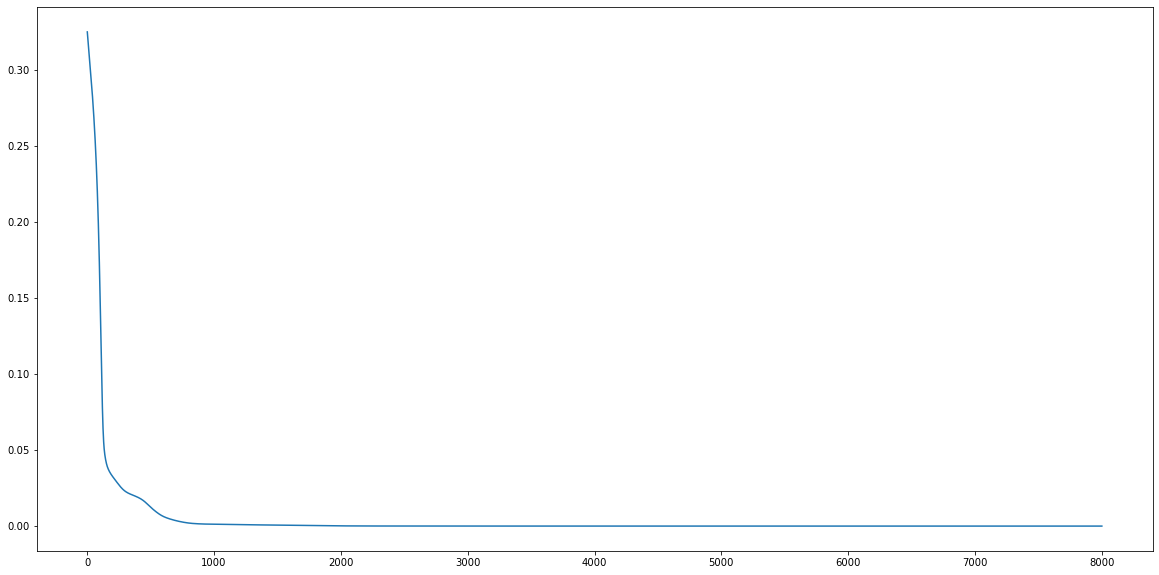

In [205]:
fig = plt.figure(figsize = (20,10))
plt.plot(train_loss_avg) 
plt.show()

In [206]:
def traverseleaf(root):
    if root is not None:
        traverseleaf(root.left)
        if root.is_leaf():
            print(root.radius)
        traverseleaf(root.right)
        return 

In [207]:
def traversebif(root):
    if root is not None:
        traversebif(root.left)
        if root.is_two_child():
            print(root.radius)
        traversebif(root.right)
        return 

In [208]:
traversebif(decoded)
print("////")
traversebif(input)

tensor([[-0.0002, -0.0002, -0.0003, -0.0004]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[0.4996, 0.4995, 0.4996, 0.4996]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
////
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0.5000, 0.5000, 0.5000, 0.5000], device='cuda:0')


In [209]:
traverseleaf(decoded)

tensor([[0.3999, 0.1251, 0.1419, 0.4994]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[0.8998, 0.6250, 0.6429, 0.9998]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[0.9982, 1.0001, 0.9994, 1.0011]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [210]:
traverseleaf(input)

tensor([0.8000, 0.2500, 0.2857, 1.0000], device='cuda:0')
tensor([0.4000, 0.1250, 0.1429, 0.5000], device='cuda:0')
tensor([0.9000, 0.6250, 0.6429, 1.0000], device='cuda:0')
tensor([1., 1., 1., 1.], device='cuda:0')
